In [39]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [4]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [40]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/home/mlut/IDLCV/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [42]:
#######Fatemeh: ignore it

size = 128

import albumentations as albu
from albumentations.pytorch import ToTensorV2

# Define a list of augmentations
train_transform = albu.Compose([
    albu.RandomResizedCrop(height=128, width=128, scale=(0.8, 1.0)),
    albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.2),
    albu.RandomGamma(p=0.2),
    albu.GaussNoise(p=0.2),
    albu.Rotate(limit=30, p=0.5),
    albu.RandomBrightness(p=0.2),
    albu.RandomContrast(p=0.2),
    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = albu.Compose([
    albu.Resize(height=128, width=128),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
 
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [7]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])


test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

                                    

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

torch.Size([64, 3, 128, 128])


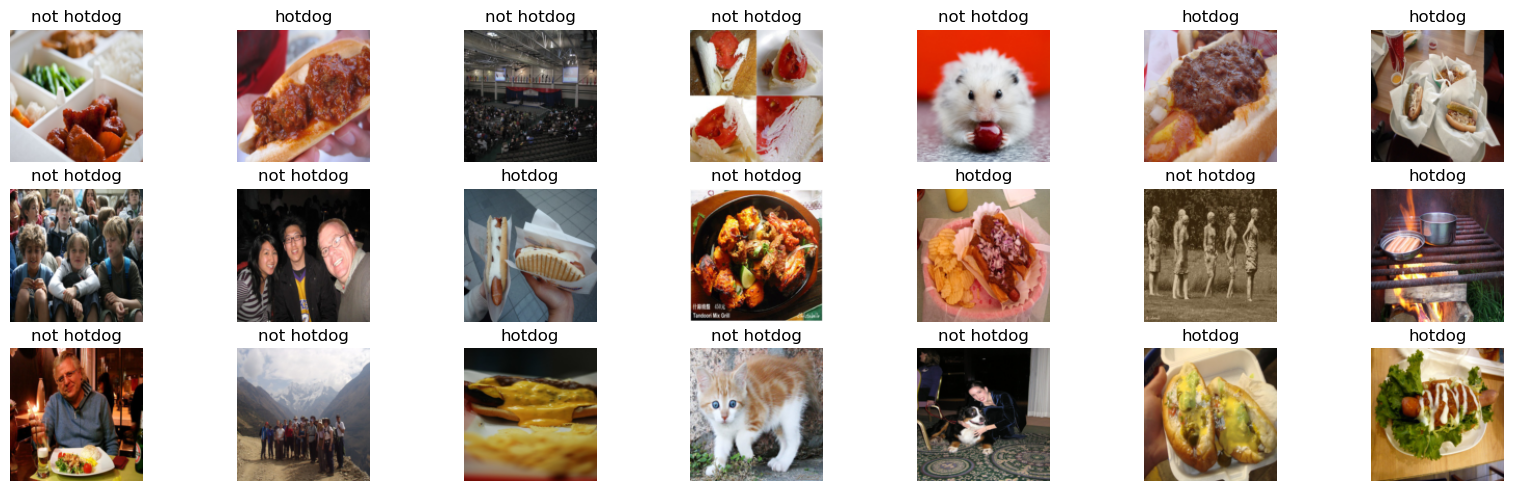

In [8]:
images, labels = next(iter(train_loader))
print(images.shape) #(64,3,128,128) ? 
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [43]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #127
                # nn.MaxPool2d(2, stride=2), #127/2 = 63
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126
                # nn.BatchNorm2d(2**4), #should return 62 ?? 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 1),
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return x

In [44]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
print(data.shape)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit
print("model works with one minibatch")

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_274548/3660485875.py", line 22, in __getitem__
    X = self.transform(image)
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/albumentations/core/composition.py", line 193, in __call__
    raise KeyError("You have to pass data to augmentations as named arguments, for example: aug(image=image)")
KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'


In [38]:
optimizer = optimizer_adam
num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        # output = output.view(output.size(0), -1)
        # output = output[0]
        # print(output.shape)
        # print(target.shape)
        # print(torch.log(output))
        # loss = F.nll_loss(torch.log(output), target)
        # loss = F.binary_cross_entropy(output, target)
        loss = loss_function(output, target.unsqueeze(1).float())
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


Saliency maps